In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!pip install --upgrade pandas

In [0]:
!ls "drive/My Drive/Colab Notebooks/data"

GoogleNews-vectors-negative300.bin.gz  news_proc.pickle


---

In [0]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import style
#Nicer style
style.use('seaborn') 

from tensorflow import keras as k

from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

In [0]:
data = pd.read_pickle('drive/My Drive/Colab Notebooks/data/news_proc.pickle').head(200_000)

In [0]:
data.head()

,type,content,title,one_hot_label
0,fake,"[2458, 4, 27, 17625, 12, 328, 5, 25587, 416, 1...","[1732, 258, 27, 7196, 2154, 4192, 88, 43, 13, ...","[0, 1, 0]"
1,fake,"[3836, 22, 506, 3059, 67, 2, 2941, 2429, 33, 3...","[6117, 13034, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0]"
2,fake,"[7, 37481, 39852, 483, 423, 24, 42, 1837, 81, ...","[6117, 13034, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0]"
3,fake,"[7, 1790, 659, 24, 846, 6786, 5428, 17, 52, 44...","[13341, 1421, 1992, 1178, 8704, 11, 13034, 387...","[0, 1, 0]"
4,fake,"[59, 24, 216, 529, 104, 11, 34925, 133, 31, 24...","[13034, 43, 39049, 43, 76, 1588, 38, 23, 8158,...","[0, 1, 0]"


In [0]:
dfake = data[data['type'] == 'fake']
dtrue = data[data['type'] == 'truth']
dclic = data[data['type'] == 'click']

data = pd.concat([dfake.head(10000), dtrue, dclic])

del dfake, dtrue, dclic


In [0]:
len_content = len(data['content'][0])
len_title = len(data['title'][0])

print("Max len content: {}".format(len_content))
print("Max len title: {}".format(len_title))

Max len content: 1645
Max len title: 13


In [0]:
model = KeyedVectors.load_word2vec_format("drive/My Drive/Colab Notebooks/data/GoogleNews-vectors-negative300.bin.gz", binary=True, limit=50000)

In [0]:
embed_mat = np.zeros((50000,300))
for i, e in model.vocab.items():
    embed_mat[e.index] = model[i]

**Tran/test split**

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['content', 'title']], data['one_hot_label'], test_size=0.4, random_state=1)

In [0]:
X_train_title = X_train['title']
X_train_content = X_train['content']

X_test_title = X_test['title']
X_test_content = X_test['content']

In [0]:
train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

In [0]:
del data
del X_train_title, X_train_content

# LSTM

In [0]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False)(title_input)
x = k.layers.LSTM(300)(inp)


#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False)(content_input)
x2 = k.layers.LSTM(300, return_sequences=True)(inp2)
x2 = k.layers.LSTM(100)(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)

out = k.layers.Dense(3, activation='softmax')(x)

model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

In [0]:
model.compile(k.optimizers.Nadam(), loss='categorical_crossentropy', metrics=['acc'])

In [0]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
content_input (InputLayer)      (None, 1527)         0                                            
__________________________________________________________________________________________________
title_input (InputLayer)        (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 1527, 300)    15000000    content_input[0][0]              
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 16, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
lstm_23 (L

In [0]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=64, epochs=15,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2)], validation_split=0.3)

Train on 1248 samples, validate on 535 samples
Epoch 1/15


In [0]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

In [0]:
from sklearn.metrics import accuracy_score, f1_score

In [0]:
test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

In [0]:
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.8023549201009251

#Redes convolucionales

In [0]:
#input_title
title_input = k.layers.Input(shape=(len_title,), name='title_input')
inp = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_title')(title_input)

x = k.layers.Conv1D(filters = 5, kernel_size=3, strides=2, activation='relu')(inp)
x = k.layers.MaxPool1D(pool_size = 4)(x)
x = k.layers.Flatten()(x)
x = k.layers.Dense(50, activation='sigmoid')(x)

#input_content
content_input = k.layers.Input(shape=(len_content,), name='content_input')
inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
                         weights=[embed_mat], trainable=False, name='embed_content')(content_input)
x2 = k.layers.Conv1D(filters = 10, kernel_size = 10, strides = 8, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)
x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='sigmoid')(x2)


#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(50, activation='relu')(x)
out = k.layers.Dense(3, activation='softmax')(x)



model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

model.compile(k.optimizers.Nadam(), loss='categorical_crossentropy', metrics=['acc'])

model.summary()



Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        (None, 13)           0                                            
__________________________________________________________________________________________________
content_input (InputLayer)      (None, 1645)         0                                            
__________________________________________________________________________________________________
embed_title (Embedding)         (None, 13, 300)      15000000    title_input[0][0]                
__________________________________________________________________________________________________
embed_content (Embedding)       (None, 1645, 300)    15000000    content_input[0][0]              
_____________________________________

In [0]:
hist = model.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=120, epochs=15,
          callbacks = [k.callbacks.EarlyStopping(monitor='val_acc', patience=2)], validation_split=0.3)

Train on 84000 samples, validate on 36000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
10680/84000 [==>...........................] - ETA: 5:26 - loss: 0.5427 - acc: 0.7546

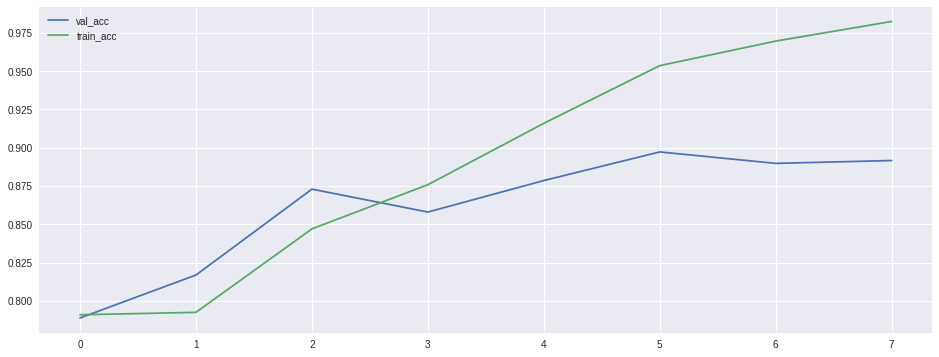

In [0]:
plt.figure(figsize=(16,6))
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['acc'], label='train_acc')
plt.legend()

In [0]:
test_pred = model.predict(test_fit)
accuracy_score(np.array(y_test.tolist()), test_pred.round())

0.9150546677880572